In [19]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix,precision_score,f1_score,average_precision_score
from scipy.stats import randint, uniform
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

In [3]:
X = pd.read_csv("data/fe/X_train_fe.csv")
y = pd.read_csv("data/fe/y_train.csv").squeeze()

In [4]:
cat_cols = [c for c in ["Sex", "Embarked", "Title"] if c in X.columns]
X = pd.get_dummies(
    X,
    columns=cat_cols,
    drop_first=True
)

In [5]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


In [6]:
param_dist = {
    "n_estimators": randint(200, 1200),
    "learning_rate": uniform(0.01, 0.19),
    "max_depth": randint(3, 10),
    "num_leaves": randint(15, 100),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_samples": randint(5, 50),
    "reg_alpha": uniform(0.0, 1.0),
    "reg_lambda": uniform(0.0, 5.0),
}


In [7]:
search = RandomizedSearchCV(
    LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=40,
    scoring="recall",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

search.fit(X, y)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifie...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': <scipy.stats....001B88F1C0A10>, 'learning_rate': <scipy.stats....001B8F36BD5B0>, 'max_depth': <scipy.stats....001B88F18F320>, 'min_child_samples': <scipy.stats....001B88F1C0B30>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User G

In [8]:
print("Best CV recall:", search.best_score_)
print("Best params:", search.best_params_)

Best CV recall: 0.7511111111111112
Best params: {'colsample_bytree': np.float64(0.6926508310689253), 'learning_rate': np.float64(0.1887470899759636), 'max_depth': 8, 'min_child_samples': 35, 'n_estimators': 738, 'num_leaves': 90, 'reg_alpha': np.float64(0.09067557900950507), 'reg_lambda': np.float64(1.08954219597159), 'subsample': np.float64(0.9272133871627314)}


In [9]:
X_test = pd.read_csv("data/fe/X_test_fe.csv")
y_test = pd.read_csv("data/fe/y_test.csv").squeeze()

In [10]:
X_test = pd.get_dummies(
    X_test,
    columns=cat_cols,
    drop_first=True
)


In [11]:
X, X_test = X.align(X_test, axis=1, fill_value=0)

In [25]:
final_model = LGBMClassifier(
    **search.best_params_,
    objective="binary",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y)

y_pred = final_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8156424581005587
Recall: 0.7536231884057971
Confusion matrix:
 [[94 16]
 [17 52]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [27]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 -accuracy
print(f'Точность R^2: {accuracy}')
print(f'Доля ошибочных классификаций: {error_rate}')

Точность R^2: 0.8156424581005587
Доля ошибочных классификаций: 0.1843575418994413


Text(50.722222222222214, 0.5, 'True Label')

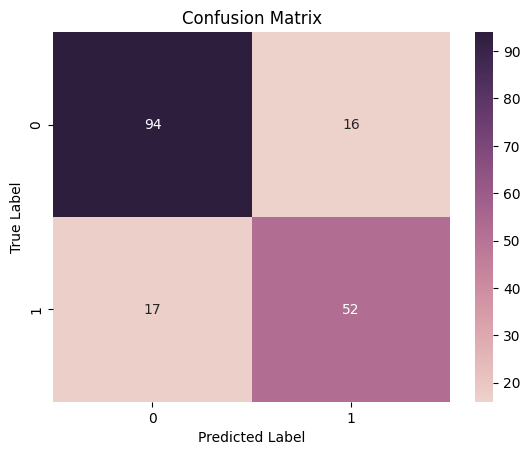

In [28]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [29]:
precision = precision_score(y_test, y_pred)
print(precision)

0.7647058823529411


In [30]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.7591240875912408


In [31]:
average_precision_score(y_test, y_pred)

0.671272152290598